In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import binom

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set_context('poster')

In [2]:
def bipolarize(Y):
    X = np.copy(Y)
    X[X > 0] = 1.0
    X[X < 0] = -1.0
    X[X == 0] = np.random.choice([-1.0, 1.0], size=len(X[X == 0]))
    return X

In [3]:
def run_sim(D,DClass,DContext,NClass,NContext):
    
    # build AM for each context
    AM = np.zeros((NContext,NClass,D),dtype=np.int8)
    seed = np.random.choice((-1,1),D).astype('int')
    for i in range(NContext):
        for j in range(NClass):
            flipIdx = np.random.permutation(D)[:DClass]
            flipBits = np.ones(D)
            flipBits[flipIdx] = -1
            AM[i,j,:] = seed*flipBits
            
    # build CM of context vectors 
    CM = np.zeros((NContext,D),dtype=np.int8)
    seed = np.random.choice((-1,1),D).astype('int')
    for i in range(NContext):
        flipIdx = np.random.permutation(D)[:DContext]
        flipBits = np.ones(D)
        flipBits[flipIdx] = -1
        CM[i,:] = seed*flipBits
        
    # calculate margin with direct superposition
    directCorrect = 0
    directIncorrect = 0
    AMsuper = bipolarize(np.sum(AM,axis=0))
    for i in range(NContext):
        contextAM = AM[i]
        d = cdist(contextAM,AMsuper,'hamming')
        directCorrect += np.mean(np.diag(d))/NContext
        directIncorrect += np.mean(d[~np.eye(d.shape[0],dtype=bool)])/NContext
    directMargin = (directIncorrect - directCorrect)/(directIncorrect + directCorrect)
    directDifference = (directIncorrect - directCorrect)
    
    # calculate random margin
    AMencoded = np.zeros(AM.shape,dtype=np.int8)
    for i in range(NContext):
        AMencoded[i] = AM[i]*CM[i]
    AMencodedSuper = bipolarize(np.sum(AMencoded,axis=0))
    encodedCorrect = 0
    encodedIncorrect = 0
    for i in range(NContext):
        contextAM = AMencoded[i]
        d = cdist(contextAM,AMencodedSuper,'hamming')
        encodedCorrect += np.mean(np.diag(d))/NContext
        encodedIncorrect += np.mean(d[~np.eye(d.shape[0],dtype=bool)])/NContext
    encodedMargin  = (encodedIncorrect - encodedCorrect)/(encodedIncorrect + encodedCorrect)
    encodedDifference = (encodedIncorrect - encodedCorrect)
    
    return [directCorrect, directIncorrect, directMargin, directDifference, encodedCorrect, encodedIncorrect, encodedMargin, encodedDifference]

In [4]:
def get_direct_correct(N,p):
    M = N-1
    return p*binom.cdf(M/2-1,M,p) + (1-p)*binom.cdf(M/2-1,M,(1-p))

def get_direct_incorrect(N,p):
    return p*binom.cdf(np.floor(N/2),N,p) + (1-p)*binom.cdf(np.floor(N/2),N,(1-p))

def get_encoded_incorrect(N,p):
    M = N-1
    p0 = 2*p*(1-p)
    q0 = 1-p0 # probability B is same
    r = 1 - binom.cdf(M/2 - 1, M, 0.5) # probability of flip when B different
    s = 1 - binom.cdf(M/2,M,0.5) # probability of flip when B same
    return p0*r + q0*s

In [5]:
D = 10000
DContext = 5000
NClass = 2

NContext = list(range(1,42,2))
distances = np.arange(0,5001,250)/D

NFlips = np.round((1 - np.sqrt(1 - 2*distances))/2*D).astype('int')
NIter = 30

directCorrect = np.zeros((len(NContext),len(NFlips)))
directIncorrect = np.zeros((len(NContext),len(NFlips)))
directMargin = np.zeros((len(NContext),len(NFlips)))
directDifference = np.zeros((len(NContext),len(NFlips)))
encodedCorrect = np.zeros((len(NContext),len(NFlips)))
encodedIncorrect = np.zeros((len(NContext),len(NFlips)))
encodedMargin = np.zeros((len(NContext),len(NFlips)))
encodedDifference = np.zeros((len(NContext),len(NFlips)))

for i,n in enumerate(NContext):
    for j,f in enumerate(NFlips):
        res = np.mean(np.vstack([np.array(run_sim(D,f,DContext,NClass,n)) for _ in range(NIter)]),axis=0)
        directCorrect[i,j] = res[0]
        directIncorrect[i,j] = res[1]
        directMargin[i,j] = res[2]
        directDifference[i,j] = res[3]
        encodedCorrect[i,j] = res[4]
        encodedIncorrect[i,j] = res[5]
        encodedMargin[i,j] = res[6]
        encodedDifference[i,j] = res[7]

/Users/andy/opt/anaconda3/envs/hdcpar/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/Users/andy/opt/anaconda3/envs/hdcpar/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


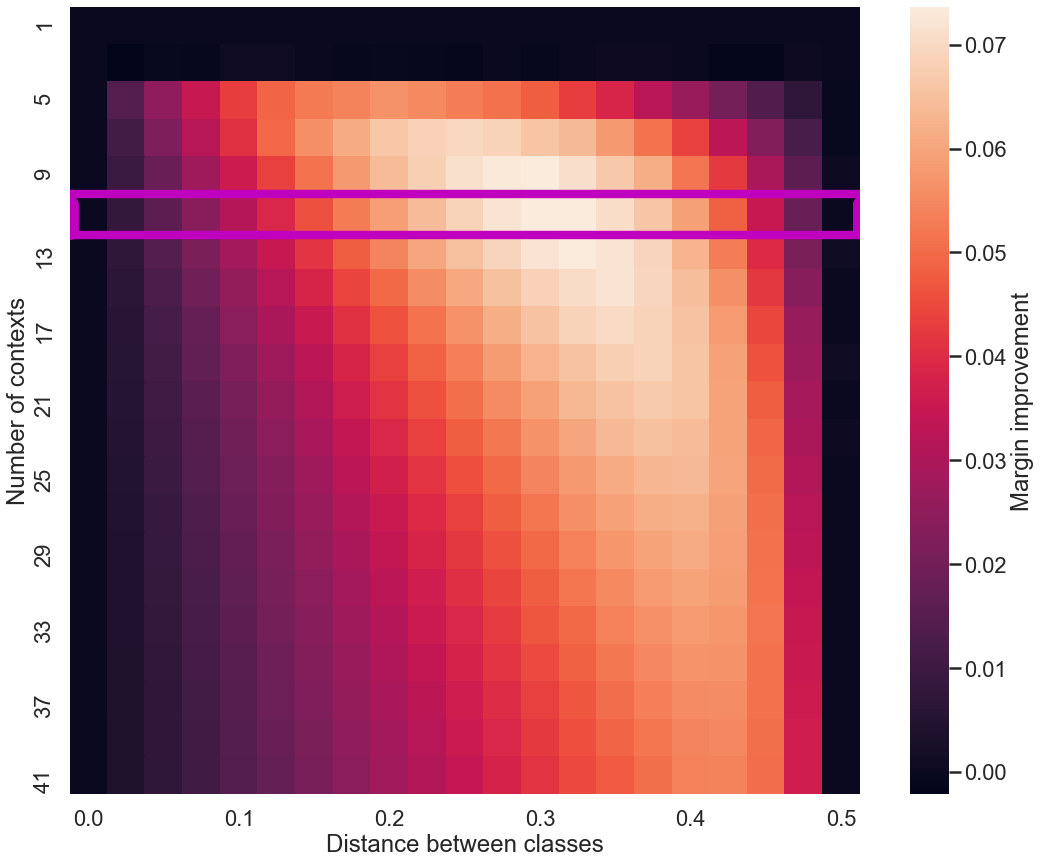

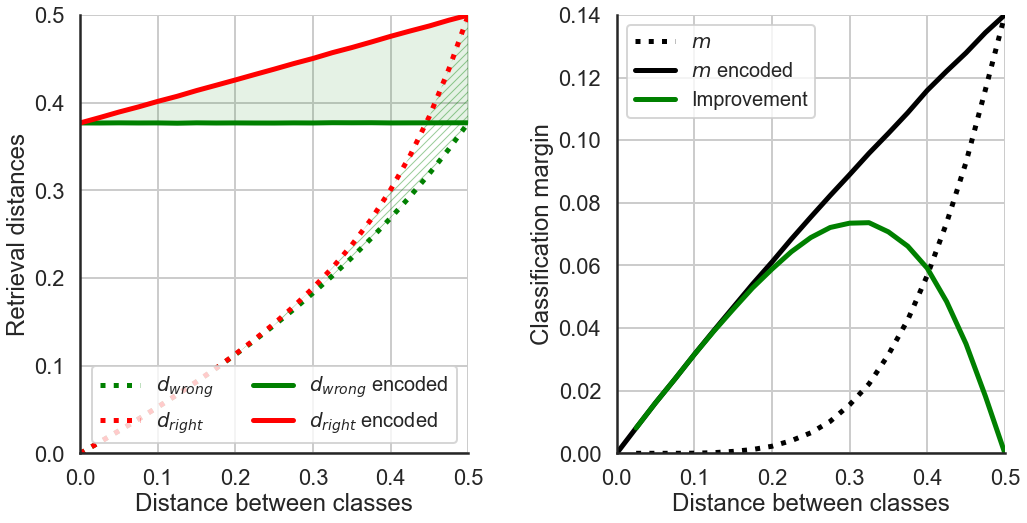

In [6]:
scale = 1.4
f,ax = plt.subplots(figsize=(11*scale*1.15,9*scale*1.15))

marginDiff = np.nan_to_num(encodedMargin - directMargin)
sns.heatmap(marginDiff,ax=ax,cbar_kws={'label': 'Margin improvement'},vmin=np.nanmin(marginDiff),vmax=np.nanmax(marginDiff))

ax.set_xticks(ax.get_xticks()[::4])
ax.set_yticks(ax.get_yticks()[::2])
xSpace = np.mean(np.diff(ax.get_xticks()))
ySpace = np.mean(np.diff(ax.get_yticks()))
ax.set_xticklabels(['%.1f' % d for i,d in enumerate(distances) if i % xSpace == 0])
ax.set_yticklabels(['%d' % n for i,n in enumerate(NContext) if i % ySpace == 0])
ax.set_xlabel('Distance between classes')
ax.set_ylabel('Number of contexts')
# ax.set_title('Retrieval noise margin improvement')

ind = np.unravel_index(np.nanargmax(marginDiff, axis=None), marginDiff.shape)
N = NContext[ind[0]]

rectCol = 'm'
ax.axvline(x=0, ymin=1-ind[0]*0.05-0.035, ymax=1-ind[0]*0.05,color=rectCol,linewidth=12*scale)
ax.axvline(x=21, ymin=1-ind[0]*0.05-0.035, ymax=1-ind[0]*0.05,color=rectCol,linewidth=10*scale)
ax.axhline(y=ind[0],color=rectCol,linewidth=6*scale)
ax.axhline(y=ind[0]+1.1,color=rectCol,linewidth=6*scale)

d = list(range(0,5500,500))
hDist = np.array(d)/D

# x = np.array([2*d*(1-d) for d in hDist])
# dCorrect = np.array([get_direct_correct(N,d) for d in hDist])
# dIncorrect = np.array([get_direct_incorrect(N,d) for d in hDist])
# eCorrect = np.array([get_direct_correct(N,d) for d in np.ones(len(hDist))*0.5])
# eIncorrect = np.array([get_encoded_incorrect(N,d) for d in hDist])

x = distances
dCorrect = directCorrect[ind[0]]
dIncorrect = directIncorrect[ind[0]]
eCorrect = encodedCorrect[ind[0]]
eIncorrect = encodedIncorrect[ind[0]]

plt.savefig("margin_heatmap.svg")

f,axes = plt.subplots(1,2,figsize=(scale*11,scale*6))
ax = axes[0]
lw = 5
ax.plot(x,dCorrect,'g:',linewidth=lw)
ax.plot(x,dIncorrect,'r:',linewidth=lw)
ax.plot(x,eCorrect,'g',linewidth=lw)
ax.plot(x,eIncorrect,'r',linewidth=lw)

# ax.fill_between(x, dCorrect, dIncorrect, color=None, edgecolor='g', hatch='//', linewidth=0)
ax.fill_between(x, dCorrect, dIncorrect, facecolor="none", hatch="///", edgecolor="g", linewidth=0.0, alpha=0.4)
ax.fill_between(x, eCorrect, eIncorrect, color='g', alpha=0.1)

ax.set_xlim((0,0.5))
ax.set_ylim((0,0.5))
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(('$d_{wrong}$','$d_{right}$','$d_{wrong}$ encoded','$d_{right}$ encoded'),fontsize='small',ncol=2,loc='lower center', bbox_to_anchor=(0.5, 0))

# ax.set_title('Margin comparison - %d contexts' % N)
ax.set_xlabel('Distance between classes')
ax.set_ylabel('Retrieval distances')



ax = axes[1]
dMargin = directMargin[ind[0]]
eMargin = encodedMargin[ind[0]]
# dMargin = directDifference[ind[0]]
# eMargin = encodedDifference[ind[0]]
marginDiff = eMargin - dMargin

ax.plot(x,dMargin,'k:',linewidth=lw)
ax.plot(x,eMargin,'k',linewidth=lw)
ax.plot(x,marginDiff,'g',linewidth=lw)

ax.set_xlim((0,0.5))
ax.set_ylim((0,0.14))
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.set_title('Margin comparison - %d contexts' % N)
ax.set_xlabel('Distance between classes')
ax.set_ylabel('Classification margin')

ax.legend(('$m$','$m$ encoded','Improvement'),fontsize='small',ncol=1,loc='upper left')

f.tight_layout(pad=2)

# plt.show()
plt.savefig("distance_comp.svg")